<h2>Initializing</h2>
<p>Import Libraries, add variables for attribute strings (to save '') and load data</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix 
from sklearn import tree
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.utils.multiclass import unique_labels

fixed_acidity = 'fixed acidity'
volatile_acidity = 'volatile acidity'
citric_acid = 'citric acid'
residual_sugar = 'residual sugar'
chlorides = 'chlorides'
free_sulfur_dioxide = 'free sulfur dioxide'
total_sulfur_dioxide = 'total sulfur dioxide'
density = 'density'
ph = 'pH'
sulphates = 'sulphates'
alcohol = 'alcohol'
quality = 'quality'
qclass = 'qclass'
ratio_to_fixed = 'ratio_to_fixed'
ratio_to_volatile = 'ratio_to_volatile'
ph_acidity = 'ph_acidity'
ratio_to_ph = 'ratio_to_ph'

In [2]:
def confusion_matrix_report(y_true, y_pred):
    cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
    column_width = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
    report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
    for i, label1 in enumerate(labels):
        report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
    return report

<p>Import red and white dataset.<br/>
Split into input matrix (independent vars) and output vector (target vars).<br/>
</p>

<p>sort for kNN (https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors) </p>

In [8]:
white = pd.read_csv("data/winequality-white1.csv")
red = pd.read_csv("data/winequality-red1.csv")
white.sort_values(by='quality',inplace=True)
red.sort_values(by='quality',inplace=True)
white_target = white[quality]
red_target = red[quality]
white_input = white.drop(quality,axis=1)
red_input = red.drop(quality,axis=1)

Add ratio of acidity to sugar as attribute.

In [9]:
#white[ph_acidity] = 7 - white[ph]
#red[ph_acidity] = 7 - red[ph]
#white_input[ratio_to_fixed]=white[residual_sugar]/white[fixed_acidity]
#white_input[ratio_to_volatile]=white[residual_sugar]/white[volatile_acidity]
#white_input[ratio_to_ph]=white[residual_sugar]/white[ph_acidity]
#red_input[ratio_to_fixed]=red[residual_sugar]/red[fixed_acidity]
#red_input[ratio_to_volatile]=red[residual_sugar]/red[volatile_acidity]
#red_input[ratio_to_ph]=red[residual_sugar]/red[ph_acidity]

<p>using log.</p>

In [10]:
#white_norm=np.log(white_input+1)
#red_norm=np.log(red_input+1)

<p>Normalize using MinMax Normalizer.</p>

In [11]:
#white_norm=(white_input-white_input.min())/(white_input.max()-white_input.min())
#red_norm=(red_input-red_input.min())/(red_input.max()-red_input.min())

<p>Normalize using Mean Normalizer.</p>

In [12]:
white_norm=(white_input-white_input.mean())/(white_input.std())
red_norm=(red_input-red_input.mean())/(red_input.std())

<p>Correlation Matrices</p>

In [13]:
wcorr = white.corr()
wcorr.style.background_gradient().set_precision(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.0227,0.289,0.089,0.0231,-0.0494,0.0911,0.265,-0.426,-0.0171,-0.121,-0.114
volatile acidity,-0.0227,1,-0.149,0.0643,0.0705,-0.097,0.0893,0.0271,-0.0319,-0.0357,0.0677,-0.195
citric acid,0.289,-0.149,1,0.0942,0.114,0.0941,0.121,0.15,-0.164,0.0623,-0.0757,-0.00921
residual sugar,0.089,0.0643,0.0942,1,0.0887,0.299,0.401,0.839,-0.194,-0.0267,-0.451,-0.0976
chlorides,0.0231,0.0705,0.114,0.0887,1,0.101,0.199,0.257,-0.0904,0.0168,-0.36,-0.21
free sulfur dioxide,-0.0494,-0.097,0.0941,0.299,0.101,1,0.616,0.294,-0.000618,0.0592,-0.25,0.00816
total sulfur dioxide,0.0911,0.0893,0.121,0.401,0.199,0.616,1,0.53,0.00232,0.135,-0.449,-0.175
density,0.265,0.0271,0.15,0.839,0.257,0.294,0.53,1,-0.0936,0.0745,-0.78,-0.307
pH,-0.426,-0.0319,-0.164,-0.194,-0.0904,-0.000618,0.00232,-0.0936,1,0.156,0.121,0.0994
sulphates,-0.0171,-0.0357,0.0623,-0.0267,0.0168,0.0592,0.135,0.0745,0.156,1,-0.0174,0.0537


In [14]:
rcorr = red.corr()
rcorr.style.background_gradient().set_precision(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.256,0.672,0.115,0.0937,-0.154,-0.113,0.668,-0.683,0.183,-0.0617,0.124
volatile acidity,-0.256,1,-0.552,0.00192,0.0613,-0.0105,0.0765,0.022,0.235,-0.261,-0.202,-0.391
citric acid,0.672,-0.552,1,0.144,0.204,-0.061,0.0355,0.365,-0.542,0.313,0.11,0.226
residual sugar,0.115,0.00192,0.144,1,0.0556,0.187,0.203,0.355,-0.0857,0.00553,0.0421,0.0137
chlorides,0.0937,0.0613,0.204,0.0556,1,0.00556,0.0474,0.201,-0.265,0.371,-0.221,-0.129
free sulfur dioxide,-0.154,-0.0105,-0.061,0.187,0.00556,1,0.668,-0.0219,0.0704,0.0517,-0.0694,-0.0507
total sulfur dioxide,-0.113,0.0765,0.0355,0.203,0.0474,0.668,1,0.0713,-0.0665,0.0429,-0.206,-0.185
density,0.668,0.022,0.365,0.355,0.201,-0.0219,0.0713,1,-0.342,0.149,-0.496,-0.175
pH,-0.683,0.235,-0.542,-0.0857,-0.265,0.0704,-0.0665,-0.342,1,-0.197,0.206,-0.0577
sulphates,0.183,-0.261,0.313,0.00553,0.371,0.0517,0.0429,0.149,-0.197,1,0.0936,0.251


<h2>Assigning classes</h2>
<p>
    Assign classes based on quality. Less than 6; 6; better than 6. Because it makes sense considering the distribution of ratings.
</p>

In [15]:
conditions = [(white['quality'] < 6),
              (white['quality'] > 6)]
choices = ['1_low', '3_high']
white['class'] = np.select(conditions, choices, default = '2_medium')

conditions = [(red['quality'] < 6),
              (red['quality'] > 6)]
red['class'] = np.select(conditions, choices, default = '2_medium')

print('class distribution fot white:')
print(white['class'].value_counts())
print('\n class distribution for red:')
print(red['class'].value_counts())

white_norm['class']=white['class']
red_norm['class']=red['class']
white_targetclass = white['class']
red_targetclass = red['class']

class distribution fot white:
2_medium    2198
1_low       1640
3_high      1060
Name: class, dtype: int64

 class distribution for red:
1_low       744
2_medium    638
3_high      217
Name: class, dtype: int64


In [16]:
white_norm_input = white_norm.drop('class', axis = 1)
red_norm_input = red_norm.drop('class', axis = 1)

In [17]:
#white_norm.loc[white_norm['class']=='3_high'].describe()
#white_norm.loc[white_norm['class']=='2_medium'].describe()
#white_norm.loc[white_norm['class']=='1_low'].describe()
white_norm_filtered = white_norm_input.drop([residual_sugar,chlorides,ph,sulphates],axis=1)
white_norm_filtered.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,alcohol
count,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03
mean,-8.565083e-15,-1.998539e-14,6.443990e-14,-6.380722e-17,-2.226113e-16,1.628816e-12,-4.325046e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.619982e+00,-1.966784e+00,-2.761461e+00,-1.958477e+00,-3.043919e+00,-2.312802e+00,-2.043089e+00
25%,-6.574340e-01,-6.770318e-01,-5.304215e-01,-7.237012e-01,-7.144009e-01,-7.706280e-01,-8.241915e-01
50%,-6.492444e-02,-1.809733e-01,-1.172660e-01,-7.691388e-02,-1.026084e-01,-9.608339e-02,-9.285319e-02
75%,5.275851e-01,4.142970e-01,4.611517e-01,6.286722e-01,6.738976e-01,6.929749e-01,7.197450e-01
max,8.704217e+00,8.152811e+00,1.095530e+01,1.491679e+01,7.097720e+00,1.502976e+01,2.995020e+00


In [18]:
#red_norm.loc[red_norm['class']=='3_high'].describe()
#red_norm.loc[red_norm['class']=='2_medium'].describe()
#red_norm.loc[red_norm['class']=='1_low'].describe()
red_norm_filtered = red_norm_input.drop([residual_sugar,chlorides,ph,sulphates],axis=1)
red_norm_filtered.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,alcohol
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,1.264661e-14,8.477896e-15,-2.005813e-15,-1.055285e-16,2.365560e-16,1.317714e-12,2.204136e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-1.898325e+00
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-8.661079e-01
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,-1.792441e-01,-2.574163e-01,1.759533e-03,-2.092427e-01
75%,5.056370e-01,6.264921e-01,7.650078e-01,4.899619e-01,4.721707e-01,5.766445e-01,6.352984e-01
max,4.353787e+00,5.876138e+00,3.742403e+00,5.365606e+00,7.372847e+00,3.678904e+00,4.201138e+00


<h2>k-NN classification<h2><p>https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#the-curse-of-dimensionality</p>

<h3>white: normalized and selected for attributes with low std/range</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1140      433       67
2_medium     406     1502      290
  3_high      54      288      718

             precision    recall  f1-score   support

      1_low       0.71      0.70      0.70      1640
   2_medium       0.68      0.68      0.68      2198
     3_high       0.67      0.68      0.67      1060

avg / total       0.69      0.69      0.69      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1313      301       26
2_medium     746     1300      152
  3_high     148      450      462

             precision    recall  f1-score   support

      1_low       0.59      0.80      0.68      1640
   2_medium       0.63      0.59      0.61      2198
     3_high       0.72      0.44      0.54      1060

avg / total       0.64      0.63      0.62      4898

3 neighbours:
3 neighbours//
         _______Prediction_

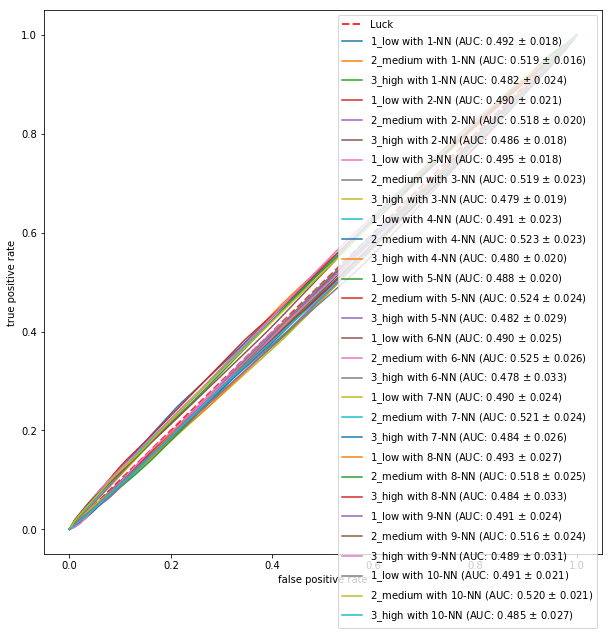

In [23]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    
    for train_indices, test_indices in cv.split(data, target):
        train_data = data[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data) 
        #print(classification_report(test_target, estimator.predict(test_data)))
        
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        
        #plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

def run_knn_report(inputs, targets):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
    for n_neighbour in range(1,11):
        print(str(n_neighbour) + " neighbours:")
        knn_estimator = KNeighborsClassifier(n_neighbour)
        for classlabel in ['1_low','2_medium','3_high']:
            mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator, inputs, targets,classlabel)
            plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
        predicted = cross_val_predict(knn_estimator,inputs,targets,cv=cv)
        print(confusion_matrix_report(targets,predicted))
        print(classification_report(targets,predicted))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()
    
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
#cv = KFold(n_splits=3)
run_knn_report(white_norm_filtered.values, white_targetclass)


<h3><i>red: </i>normalized and selected for attributes with low std/range</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low     552      163       29
2_medium     161      401       76
  3_high      21       63      133

             precision    recall  f1-score   support

      1_low       0.75      0.74      0.75       744
   2_medium       0.64      0.63      0.63       638
     3_high       0.56      0.61      0.58       217

avg / total       0.68      0.68      0.68      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low     633      103        8
2_medium     297      304       37
  3_high      45       99       73

             precision    recall  f1-score   support

      1_low       0.65      0.85      0.74       744
   2_medium       0.60      0.48      0.53       638
     3_high       0.62      0.34      0.44       217

avg / total       0.63      0.63      0.61      1599

3 neighbours:
3 neighbours//
         _______Prediction_

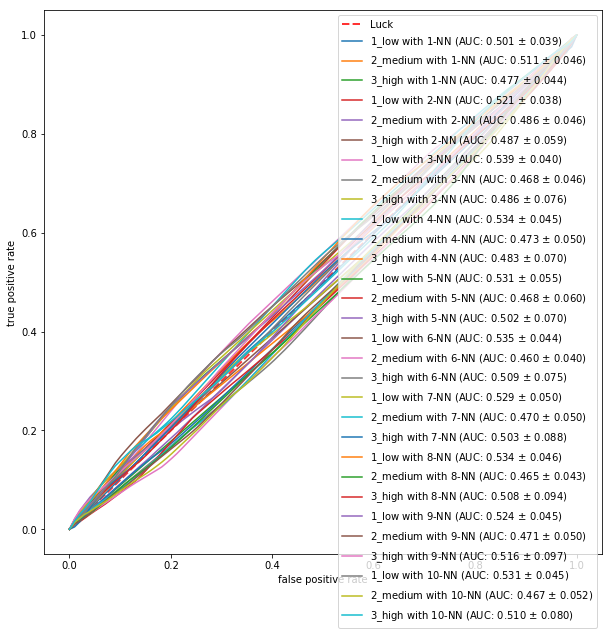

In [24]:
run_knn_report(red_norm_filtered.values,red_targetclass)

<h3>white: normalized unselected</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1156      416       68
2_medium     381     1538      279
  3_high      59      276      725

             precision    recall  f1-score   support

      1_low       0.72      0.70      0.71      1640
   2_medium       0.69      0.70      0.69      2198
     3_high       0.68      0.68      0.68      1060

avg / total       0.70      0.70      0.70      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1308      303       29
2_medium     735     1331      132
  3_high     132      445      483

             precision    recall  f1-score   support

      1_low       0.60      0.80      0.69      1640
   2_medium       0.64      0.61      0.62      2198
     3_high       0.75      0.46      0.57      1060

avg / total       0.65      0.64      0.63      4898

3 neighbours:
3 neighbours//
         _______Prediction_

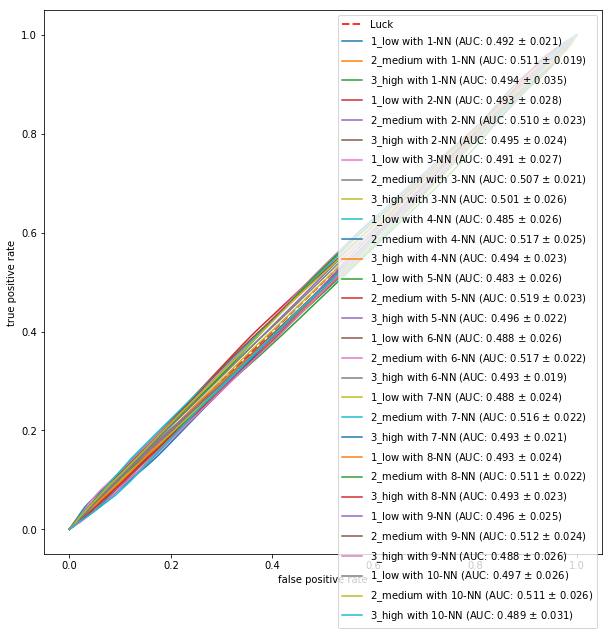

In [25]:
run_knn_report(white_norm_input.values,white_targetclass)

<h3><i>red: </i> normalized unselected</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low     554      166       24
2_medium     158      412       68
  3_high      21       61      135

             precision    recall  f1-score   support

      1_low       0.76      0.74      0.75       744
   2_medium       0.64      0.65      0.65       638
     3_high       0.59      0.62      0.61       217

avg / total       0.69      0.69      0.69      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low     627      109        8
2_medium     286      316       36
  3_high      39      105       73

             precision    recall  f1-score   support

      1_low       0.66      0.84      0.74       744
   2_medium       0.60      0.50      0.54       638
     3_high       0.62      0.34      0.44       217

avg / total       0.63      0.64      0.62      1599

3 neighbours:
3 neighbours//
         _______Prediction_

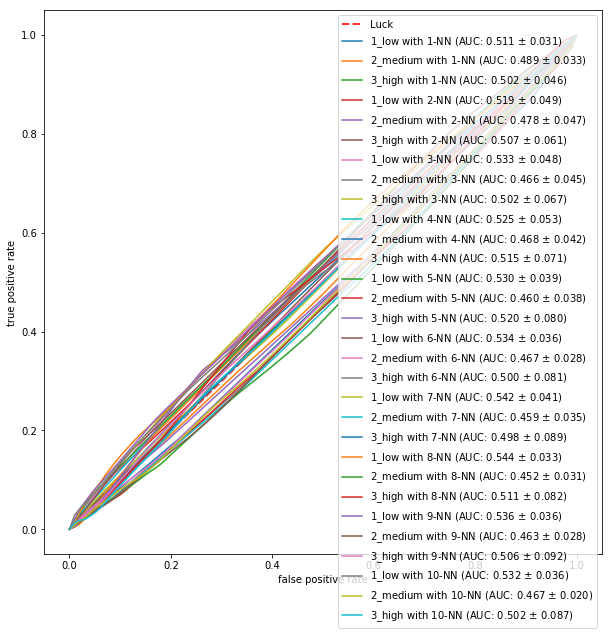

In [26]:
run_knn_report(red_norm_input.values,red_targetclass)

<h3> white: unfiltered, unnormalized <h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1052      450      138
2_medium     437     1435      326
  3_high     107      325      628

             precision    recall  f1-score   support

      1_low       0.66      0.64      0.65      1640
   2_medium       0.65      0.65      0.65      2198
     3_high       0.58      0.59      0.58      1060

avg / total       0.64      0.64      0.64      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1234      345       61
2_medium     856     1200      142
  3_high     265      467      328

             precision    recall  f1-score   support

      1_low       0.52      0.75      0.62      1640
   2_medium       0.60      0.55      0.57      2198
     3_high       0.62      0.31      0.41      1060

avg / total       0.58      0.56      0.55      4898

3 neighbours:
3 neighbours//
         _______Prediction_

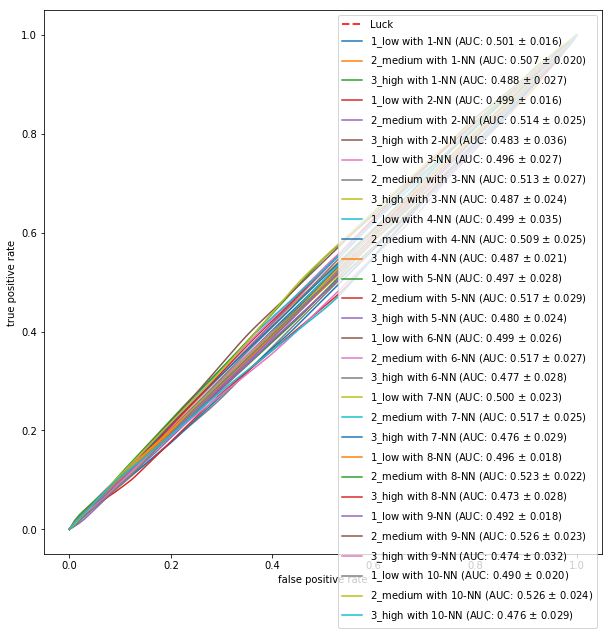

In [27]:
run_knn_report(white_input.values,white_targetclass)

<h3>red, unnormalized, unselected</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low     518      188       38
2_medium     181      398       59
  3_high      28       75      114

             precision    recall  f1-score   support

      1_low       0.71      0.70      0.70       744
   2_medium       0.60      0.62      0.61       638
     3_high       0.54      0.53      0.53       217

avg / total       0.65      0.64      0.64      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
           1_low 2_medium   3_high
   1_low     605      128       11
2_medium     353      257       28
  3_high      62       95       60

             precision    recall  f1-score   support

      1_low       0.59      0.81      0.69       744
   2_medium       0.54      0.40      0.46       638
     3_high       0.61      0.28      0.38       217

avg / total       0.57      0.58      0.55      1599

3 neighbours:
3 neighbours//
         _______Prediction_

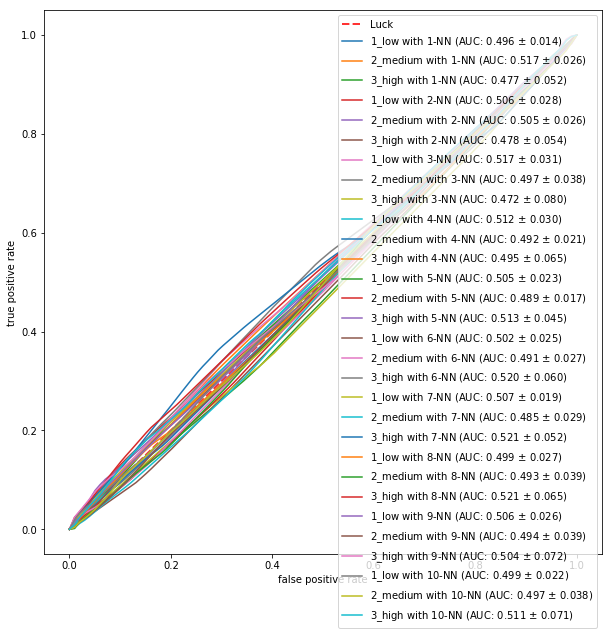

In [28]:
run_knn_report(red_input.values,red_targetclass)

In [29]:
def run_knc_report(inputs, targets):
    knc_estimator = NearestCentroid()
    predicted = cross_val_predict(knc_estimator,inputs,targets,cv=cv)
    print(confusion_matrix_report(targets,predicted))
    print(classification_report(targets,predicted))

In [30]:
run_knc_report(white_norm_input.values,white_targetclass)

         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1081      266      293
2_medium     785      537      876
  3_high     139      181      740

             precision    recall  f1-score   support

      1_low       0.54      0.66      0.59      1640
   2_medium       0.55      0.24      0.34      2198
     3_high       0.39      0.70      0.50      1060

avg / total       0.51      0.48      0.46      4898



In [31]:
run_knc_report(red_norm_input.values,red_targetclass)

         _______Prediction_______
           1_low 2_medium   3_high
   1_low     541      145       58
2_medium     217      220      201
  3_high      11       43      163

             precision    recall  f1-score   support

      1_low       0.70      0.73      0.72       744
   2_medium       0.54      0.34      0.42       638
     3_high       0.39      0.75      0.51       217

avg / total       0.59      0.58      0.57      1599



In [32]:
def run_kncs_report(inputs, targets,thresh=0):
    knc_estimator = NearestCentroid(shrink_threshold=thresh)
    predicted = cross_val_predict(knc_estimator,inputs,targets,cv=cv)
    print(confusion_matrix_report(targets,predicted))
    print(classification_report(targets,predicted))

In [33]:
run_kncs_report(white_norm_input.values,white_targetclass)

         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1081      266      293
2_medium     785      537      876
  3_high     139      181      740

             precision    recall  f1-score   support

      1_low       0.54      0.66      0.59      1640
   2_medium       0.55      0.24      0.34      2198
     3_high       0.39      0.70      0.50      1060

avg / total       0.51      0.48      0.46      4898



In [34]:
for t in range (0,1000,100):
    t = t/100000
    print(t)
    run_kncs_report(white_norm_input.values,white_targetclass,t)

0.0
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1081      266      293
2_medium     785      537      876
  3_high     139      181      740

             precision    recall  f1-score   support

      1_low       0.54      0.66      0.59      1640
   2_medium       0.55      0.24      0.34      2198
     3_high       0.39      0.70      0.50      1060

avg / total       0.51      0.48      0.46      4898

0.001
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1081      266      293
2_medium     785      537      876
  3_high     139      181      740

             precision    recall  f1-score   support

      1_low       0.54      0.66      0.59      1640
   2_medium       0.55      0.24      0.34      2198
     3_high       0.39      0.70      0.50      1060

avg / total       0.51      0.48      0.46      4898

0.002
         _______Prediction_______
           1_low 2_medium   3_high
   1_low    1081      266    

In [35]:
print(white_norm_input.describe())

       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   4.898000e+03      4.898000e+03  4.898000e+03    4.898000e+03   
mean   -8.565083e-15     -1.998539e-14  6.443990e-14    1.256968e-15   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -3.619982e+00     -1.966784e+00 -2.761461e+00   -1.141827e+00   
25%    -6.574340e-01     -6.770318e-01 -5.304215e-01   -9.249530e-01   
50%    -6.492444e-02     -1.809733e-01 -1.172660e-01   -2.348977e-01   
75%     5.275851e-01      4.142970e-01  4.611517e-01    6.917479e-01   
max     8.704217e+00      8.152811e+00  1.095530e+01    1.171292e+01   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  4.898000e+03         4.898000e+03          4.898000e+03  4.898000e+03   
mean   2.245493e-15        -6.380722e-17         -2.226113e-16  1.628816e-12   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.683102e+00        -1.9

In [36]:
print(red_targetclass)

1478     1_low
832      1_low
899      1_low
1374     1_low
459      1_low
517      1_low
1469     1_low
690      1_low
1505     1_low
1299     1_low
724      1_low
647      1_low
151      1_low
1293     1_low
927      1_low
261      1_low
45       1_low
266      1_low
937      1_low
1261     1_low
833      1_low
633      1_low
1124     1_low
1276     1_low
1480     1_low
170      1_low
73       1_low
161      1_low
1307     1_low
167      1_low
         ...  
896     3_high
339     3_high
1125    3_high
1201    3_high
335     3_high
492     3_high
334     3_high
1452    3_high
898     3_high
1451    3_high
901     3_high
1450    3_high
1269    3_high
588     3_high
498     3_high
1061    3_high
278     3_high
440     3_high
828     3_high
455     3_high
481     3_high
1202    3_high
267     3_high
1120    3_high
390     3_high
495     3_high
1403    3_high
1090    3_high
1449    3_high
1549    3_high
Name: class, Length: 1599, dtype: object
